In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Depth Estimation <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/depth_estimation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

In [ ]:
import sys
sys.path.append("/devel/dinov2")

## Utilities

In [ ]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F

from dinov2.eval.depth.models import build_depther


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

## Load pretrained backbone

In [ ]:
import numpy as np
from torchvision import transforms as pth_transforms
import cv2
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
import sys
sys.path.append("/devel/dinov2")

BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
    "reg_small" : "vits14_reg"
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

# Load image

In [ ]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

# EXAMPLE_IMAGE_URL = "https://raw.githubusercontent.com/Epsilon8854/dinov2/main/images/test/inha_desk.jpg"
# EXAMPLE_IMAGE_URL = "https://raw.githubusercontent.com/Epsilon8854/dinov2/main/images/test/3dvr_row_res.jpg"
# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

# image = load_image_from_url(EXAMPLE_IMAGE_URL)
image = Image.open('/devel/dinov2/images/test/input.png')

display(image)
image.size


In [ ]:

image = image.convert('RGB')
patch_size = 14
image_size = (224, 224)
transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
img = transform(image).cuda()

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

print("img.shape",img.shape)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

In [ ]:

from dinov2.models.vision_transformer import vit_small, vit_large

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = vit_small(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            #ffn_layer="mlp",
            block_chunks=0
    )
for p in model.parameters():
        p.requires_grad = False
model.to(device)
model.eval()

In [ ]:
attentions = model.get_last_self_attention(img.to(device))
print(attentions.shape)

# Visualization

In [ ]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_small, vit_large

import urllib

import mmcv
from mmcv.runner import load_checkpoint
from math import ceil, sqrt
def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")
    
if __name__ == '__main__':
    image_size = (224, 224)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # init model
    model = vit_small(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            #ffn_layer="mlp",
            block_chunks=0
    )
    # load model\
    # model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
    backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    # load image
    img = Image.open('/devel/dinov2/images/test/input.png')
    # img = Image.open('cow-on-the-beach2.jpg')
    # EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

    # img = load_image_from_url(EXAMPLE_IMAGE_URL)
    img = img.convert('RGB')
    
    # resize image image_size = (952, 952)
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)
    print("img.shape",img.shape)

    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print("w_featmap",w_featmap,"h_featmap",h_featmap)
    print("img.shape",img.shape)
    print(model.__dict__)
    attentions = model.get_last_self_attention(img.to(device))

    nh = attentions.shape[1] # number of head

    # batch x head x ? x ?
    # attentions.shape torch.Size([1, 16, 4625, 4625])
    print("attentions.shape",attentions.shape)
    # we keep only the output patch attention
    # for every patch
    attention = attentions[0, :, 0, 1:].reshape(nh, -1)
    # attentions.shape torch.Size([16, 4624])
    print("attentions.shape",attentions.shape)
    # weird: one pixel gets high attention over all heads?
    print(torch.max(attentions, dim=1)) 
    # attentions[:, 283] = 0 

    attention = attention.reshape(nh, w_featmap, h_featmap)
    attention = nn.functional.interpolate(attention.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    os.makedirs(output_dir, exist_ok=True)



    # for j in range(nh):
    #     fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    #     plt.imsave(fname=fname, arr=attentions[j], format='png')
    #     print(f"{fname} saved.")
    N = int(ceil(sqrt(nh)))  # Calculate N x N grid size for nh images

    fig, axes = plt.subplots(N, N, figsize=(20, 20))  # Adjust figsize as needed
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for j in range(nh):
        
        axes[j].imshow(attention[j],cmap="jet")
        axes[j].axis('off')  # Hide axis
        axes[j].set_title(f"Head {j}")  # Optional: add titles

    # Hide any unused subplots
    for k in range(j + 1, N * N):
        axes[k].axis('off')
 
    plt.tight_layout()
    output_fname = os.path.join(output_dir, "combined_attentions.png")  # Define your output file name
    plt.savefig(output_fname)  # Save the figure as a single image
    # plt.show(fig)  # Close the figure to free memory

In [ ]:
discard_ratio = 0.9
att_mat = attentions.detach().cpu()
attention_heads_fused = att_mat.max(axis=1)[0]

flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
_, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
indices = indices[indices != 0]
flat[0, indices] = 0
print("attention_heads_fused",attention_heads_fused.shape)
I = torch.eye(attention_heads_fused.size(-1))
a = attention_heads_fused/ attention_heads_fused.sum(dim=-1)

mask = attention_heads_fused[0,0,1:].reshape(16 ,16)
# plt.imshow(mask,cmap='jet')
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    cam = heatmap_rgb + np.float32(img)
    
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

image = np.array(image)
rollout_mask = np.array(mask/mask.max())  # Convert to numpy array if not already one
# print(rollout_mask.shape)
resized_rollout_mask = cv2.resize(rollout_mask, (image.shape[1],image.shape[0]) )
print("resized_rollout_mask",resized_rollout_mask.shape)
heatmap = show_mask_on_image(image,resized_rollout_mask)
plt.imshow(heatmap)

In [ ]:
plt.imshow(mask,cmap='jet')


# Attention rollout

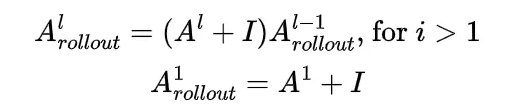

In [ ]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    print("result",result.shape)
    print("attentions",attentions.shape)
    with torch.no_grad():
        # for attention in attentions:
        print("attention",attentions.shape)
        if head_fusion == "mean":
            attention_heads_fused = attentions.mean(axis=1)
        elif head_fusion == "max":
            attention_heads_fused = attentions.max(axis=1)[0]
        elif head_fusion == "min":
            attention_heads_fused = attentions.min(axis=1)[0]
        else:
            raise "Attention head fusion type Not supported"

        # Drop the lowest attentions, but
        # don't drop the class token
        flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
        _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
        indices = indices[indices != 0]
        flat[0, indices] = 0
        print("attention_heads_fused",attention_heads_fused.shape)
        I = torch.eye(attention_heads_fused.size(-1))
        a = (attention_heads_fused + 1.0*I)/2
        a = a / a.sum(dim=-1)

        result = torch.matmul(a, result)

        print("result",result.shape)
        mask = result[0, 0 , 1 :]
        mask = mask / torch.max(mask)
        # In case of 224x224 image, this brings us from 196 to 14
        # width = int(mask.size(-1)**0.5)
        # mask = mask.reshape(width, width).numpy()
        # mask = mask / np.max(mask)
        # mask = result[0,1:]
        return mask    

print("attentions",attentions.shape)


rollout_mask = rollout(attentions.detach().cpu(), discard_ratio=0.9, head_fusion='max')
print("rst",rollout_mask.shape)
plt.imshow(rollout_mask.reshape(68,68) ,cmap = 'jet')

# mask on image

In [ ]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    cam = heatmap_rgb + np.float32(img)
    
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

image = np.array(image)
rollout_mask = np.array(rollout_mask/rollout_mask.max())  # Convert to numpy array if not already one
print(rollout_mask.shape)
resized_rollout_mask = cv2.resize(rollout_mask.reshape(68,68), (image.shape[1],image.shape[0]) )
print("resized_rollout_mask",resized_rollout_mask.shape)
heatmap = show_mask_on_image(image,resized_rollout_mask)
plt.imshow(heatmap)

In [ ]:
print(resized_rollout_mask.min())
heatmap = cv2.applyColorMap(np.uint8(255 * resized_rollout_mask), cv2.COLORMAP_JET)
heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

plt.imshow(heatmap_rgb,cmap="jet")

In [ ]:
plt.imshow(rst)

In [ ]:
attentions.shape

## Load pretrained depth head

In [ ]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "nyu" # in ("nyu", "kitti")
HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
model.cuda()

## Load sample image

In [ ]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")

# EXAMPLE_IMAGE_URL = "https://raw.githubusercontent.com/Epsilon8854/dinov2/main/images/test/inha_desk.jpg"
# EXAMPLE_IMAGE_URL = "https://raw.githubusercontent.com/Epsilon8854/dinov2/main/images/test/3dvr_row_res.jpg"
EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

image = load_image_from_url(EXAMPLE_IMAGE_URL)

display(image)

In [ ]:
import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),  
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = image.resize((scale_factor * image.width, scale_factor * image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)

## Estimate depth on sample image

In [ ]:
dp_img =result.squeeze().cpu().numpy()
dp_img.max

In [ ]:
import numpy as np
import trimesh
from skimage.measure import block_reduce

def depth_image_to_point_cloud(depth_image, camera_intrinsics, downsample_factor=1):
    """
    Convert a depth image to a point cloud.

    Parameters:
    - depth_image: A 2D numpy array of depth values.
    - camera_intrinsics: A numpy array representing the camera intrinsic matrix.
    - downsample_factor: Factor to downsample the depth image to reduce the number of points.

    Returns:
    - points: A (N, 3) numpy array of 3D point coordinates.
    """
    # Optionally downsample the image for faster processing
    if downsample_factor > 1:
        depth_image = block_reduce(depth_image, (downsample_factor, downsample_factor), np.mean)

    # Get the shape of the depth image
    height, width = depth_image.shape

    # Create a grid of coordinates corresponding to the intrinsic coordinates
    ix, iy = np.meshgrid(range(width), range(height))

    # Convert depth image to 3D point coordinates
    x = (ix - camera_intrinsics[0, 2]) * depth_image / camera_intrinsics[0, 0]
    y = (iy - camera_intrinsics[1, 2]) * depth_image / camera_intrinsics[1, 1]
    z = depth_image

    # Stack to get 3D points
    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)

    # Filter points with no depth
    points = points[~np.isnan(points).any(axis=1)]

    return points

# Example usage
# Load your depth image (assuming it's already loaded as `depth_image`)
# Define your camera intrinsics matrix (assuming it's already defined as `camera_intrinsics`)
# points = depth_image_to_point_cloud(depth_image, camera_intrinsics)

# Create a point cloud object
# cloud = trimesh.points.PointCloud(points)

# Optionally, to create a mesh from the point cloud, you might need additional steps that are not covered here due to complexity.

# Visualize the point cloud
# cloud.show()


In [ ]:
# import numpy as np
# import trimesh

# Assuming `depth_data` is your NumPy array with depth information
# and `camera_intrinsics` is your camera intrinsic matrix
# camera_intrinsics = np.array([[1911.6 ,0,1496],[0,2549.5,1496],[0,0,1]])
camera_intrinsics = np.array([[360 ,0,320],[0,360,857],[0,0,1]])
# if isinstance(depth_image, Image.Image):
#     depth_image = np.array(depth_image)
# Convert the depth data to a 3D point cloud (see previous detailed function)
points = depth_image_to_point_cloud(dp_img, camera_intrinsics)



In [ ]:

if isinstance(image, Image.Image):
    image = np.array(image)
# Create a trimesh point cloud object
cloud = trimesh.points.PointCloud(points)
cloud.colors = image.reshape(-1,3)
# Visualize
scene = trimesh.Scene([cloud])
scene.show()
cloud.export('point_cloud.ply')


In [ ]:
if isinstance(image, Image.Image):
    image = np.array(image)

In [ ]:
image.reshape(-1,3).shape

In [ ]:
points.shape

/devel/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/devel/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/devel/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/opt/conda/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


img.shape torch.Size([3, 448, 448])
w_featmap 32 h_featmap 32
img.shape torch.Size([1, 3, 448, 448])
{'training': False, '_parameters': OrderedDict([('cls_token', Parameter containing:
tensor([[[ 0.0075, -0.0008, -0.0064,  ..., -0.0057,  0.0033, -0.0003]]],
       device='cuda:0')), ('pos_embed', Parameter containing:
tensor([[[ 7.5251e-03, -7.9373e-04, -6.3555e-03,  ..., -5.7206e-03,
           3.2599e-03, -3.1836e-04],
         [-1.2054e-02,  1.2180e-02,  6.5956e-04,  ...,  1.6691e-02,
          -1.0270e-02, -3.0321e-03],
         [-9.2383e-03,  1.0009e-02,  1.2375e-03,  ...,  1.4770e-02,
          -7.6802e-03,  1.0267e-02],
         ...,
         [-3.8738e-04,  9.7813e-04,  1.1255e-02,  ...,  5.1727e-03,
          -2.9161e-04,  9.5271e-03],
         [ 5.9557e-03,  2.6298e-03,  1.2338e-02,  ...,  2.6801e-03,
           3.5318e-05,  1.7803e-02],
         [ 1.4453e-02,  4.6018e-03,  1.2395e-02,  ...,  2.8781e-03,
           1.1586e-03,  2.1186e-02]]], device='cuda:0')), ('mask_token', 

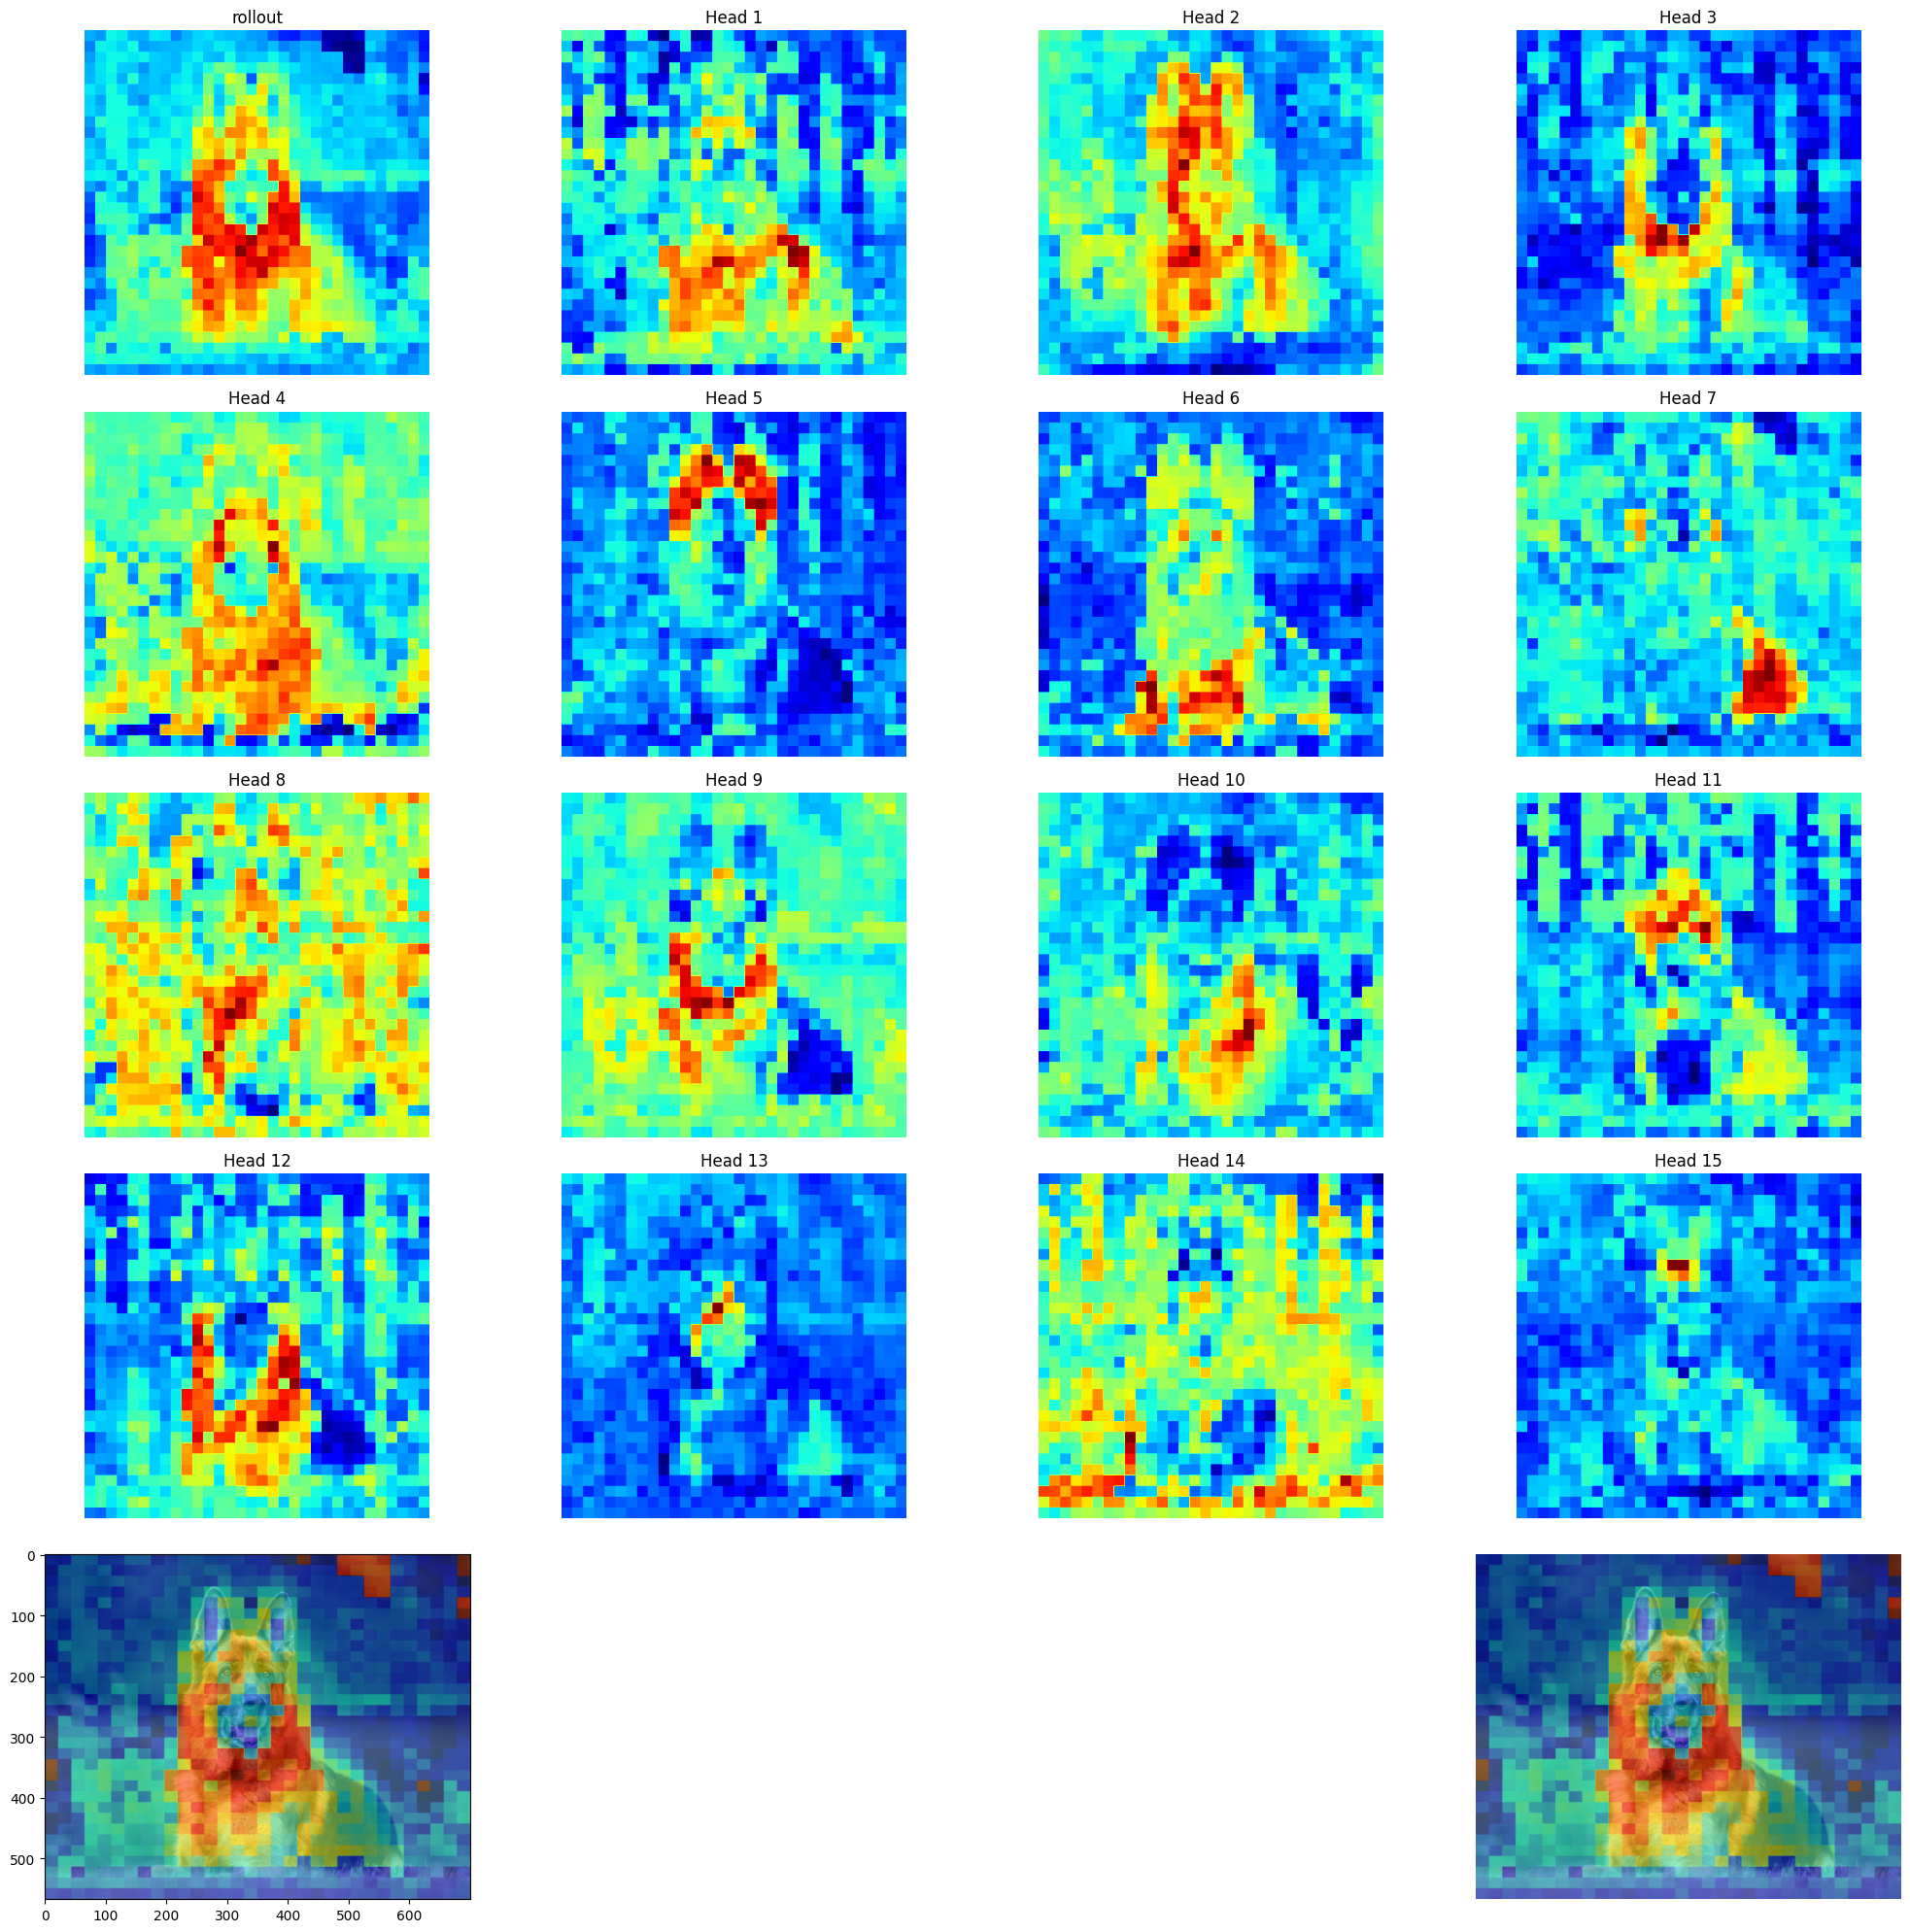

In [1]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from urllib.request import urlretrieve

sys.path.append("/devel/dinov2")


BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
    "reg_small" : "vits14_reg"
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"
from dinov2.models.vision_transformer import vit_small, vit_large

import urllib

import mmcv
from mmcv.runner import load_checkpoint
from math import ceil, sqrt
def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")
    
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    cam = heatmap_rgb + np.float32(img)
    
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

if __name__ == '__main__':
    image_size = (448, 448)
    output_dir = './images/result'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # init model
    model = vit_large(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            #ffn_layer="mlp",
            block_chunks=0
    )
    # load model\
    # model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
    model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    # load image
    # img = Image.open('/devel/dinov2/images/test/input.png')
    # img = Image.open('cow-on-the-beach2.jpg')
    # EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
    # EXAMPLE_IMAGE_URL = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg"
    # img_url = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg"
    # urlretrieve(img_url, "attention_data/img.jpg")
    # img = load_image_from_url(EXAMPLE_IMAGE_URL)
    # img = img.convert('RGB')
    img = Image.open("/devel/dinov2/notebooks/asd1.jpg")

    # resize image image_size = (952, 952)
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)
    print("img.shape",img.shape)

    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print("w_featmap",w_featmap,"h_featmap",h_featmap)
    print("img.shape",img.shape)
    print(model.__dict__)
    attentions = model.get_last_self_attention(img.to(device))

    nh = attentions.shape[1] # number of head

    # batch x head x (patch +1) x (patch +1)?
    # attentions.shape torch.Size([1, 16, 4625, 4625])
    print("attentions.shape",attentions.shape)
    # attentions = 1 x 16 x 4625 x 4625
    # we keep only the output patch attention
    # for every patch
    attention = attentions[0, :, 0, 1:].reshape(nh, -1)
    print("attention.shape",attention.shape)
    # attention = 1 x 16 x 4625 x 4625

    attention_mean = attentions.mean(dim=1)[0,0,1:]

    # attentions.shape torch.Size([16, 4624])
    print("attentions.shape",attentions.shape)
    # weird: one pixel gets high attention over all heads?
    # print(torch.max(attentions, dim=1)) 
    # attentions[:, 283] = 0 

    attention = attention.reshape(nh, w_featmap, h_featmap)
    print("nh, w_featmap, h_featmap",nh, w_featmap, h_featmap)
    
    attention_mean = attention_mean.reshape(1, w_featmap, h_featmap)
    print("attention_map",attentions.shape)
    attention = nn.functional.interpolate(attention.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    print("attention_map after interpolate",attention.shape)

    attention_mean = nn.functional.interpolate(attention_mean.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    os.makedirs(output_dir, exist_ok=True)



    # for j in range(nh):
    #     fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    #     plt.imsave(fname=fname, arr=attentions[j], format='png')
    #     print(f"{fname} saved.")
    N = int(ceil(sqrt(nh)))  # Calculate N x N grid size for nh images

    fig, axes = plt.subplots(N+1, N, figsize=(20, 20))  # Adjust figsize as needed
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for j in range(nh):
        axes[j].imshow(attention[j],cmap="jet")
        axes[j].axis('off')  # Hide axis
        axes[j].set_title(f"Head {j}")  # Optional: add titles

    axes[0].imshow(attention_mean[0]/attention_mean.max(),cmap="jet")
    axes[0].axis('off')  # Hide axis
    axes[0].set_title(f"rollout")  # Optional: add titles

    ## draw attention on image
    

    # Hide any unused subplots
    for k in range(j + 2, N * (N+1)):
        axes[k].axis('off')

    plt.tight_layout()
    # plt.show()  # Close the figure to free memory
    print("end")


    img = Image.open("/devel/dinov2/notebooks/asd1.jpg")
    image = np.array(img)
    rollout_mask = attention_mean[0]
    print(rollout_mask.shape)
    resized_rollout_mask = cv2.resize(rollout_mask/rollout_mask.max(), (image.shape[1],image.shape[0]) )
    print("resized_rollout_mask",resized_rollout_mask.shape)

    heatmap = show_mask_on_image(image,resized_rollout_mask)
    axes[j+1].imshow(heatmap)
    plt.imshow(heatmap)
    # output_fname = os.path.join(output_dir, "combined_attentions.png")  # Define your output file name
    # plt.savefig(output_fname)  # Save the figure as a single image
    # cv2.imshow('heatmap only',heatmap)

In [2]:
cv2.imshow('heatmap only',heatmap)
cv2.waitKey(0)
cv2.destroyAllWindows()


: 